[In English](https://marieevelb.github.io/jupyter-notebook/Arthur/)  

![ECCC logo](https://eccc-msc.github.io/open-data/img_eccc-logo.png)  

[TdM](https://eccc-msc.github.io/open-data/readme_fr/) > [Aperçu de l'utilisation](https://eccc-msc.github.io/open-data/usage/readme_fr/) > Outil d'aide à la décision en Python  

# Cas d'utilisation : utiliser les données ouvertes du Service météorologique du Canada pour l'aide à la décision

## Introduction

Les données des services web géospatiaux [GeoMet du Service météorologique du Canada](https://eccc-msc.github.io/open-data/msc-geomet/readme_fr/) peuvent aisément être intégrées à des outils d'aide à la décision afin de faciliter la prise de décisions critiques. Cet exemple de cas d'utilisation vous montrera comment extraire et traiter les données météorologiques brutes à l'aide du langage de programmation [Python](https://www.python.org/) afin de créer un outil d'aide à la décision basé sur la notion du rapport coût-perte. Il vous permettra d'apprendre comment:
* Accéder aux données météorologiques de GeoMet du SMC et les interroger;
* Effectuer des requêtes pour obtenir les données d'une couche spécifique à un lieu précis; 
* Effectuer des requêtes temporelles;
* Afficher les résultats sous forme de graphique et de tableau.


## Création d'un outil d'aide à la décision

Prenons la situation suivante: un propriétaire de crèmerie nommé Arthur souhaite planifier le nombre d'employés qu'il y aura chaque jour à la crèmerie à l'aide des prévisions du Service météorologique du Canada. En effet, comme les journées chaudes de l'été amènent beaucoup plus de clients que les journées plus froides, il souhaite utiliser un outil d'aide à la décision afin de déterminer quel nombre d'employés lui permettra de maximiser ses profits chaque jour. Selon ses calculs, la crèmerie accueille 300 clients en moyenne les journées où la température est de 25°C ou plus alors qu'elle en accueille seulement 150 les journées où la température est inférieure à 25°C. La crèmerie ne nécessite normalement qu'un seul employé, mais un deuxième est nécessaire pour réussir à servir l'ensemble des clients lorsqu'il y a plus de 200 clients dans une journée.

Afin de déterminer le nombre d'employés à mettre à l'horaire, Arthur va comparer la probabilité que la température soit égale ou supérieure à 25°C au rapport coût-perte de faire travailler un deuxième employé. Pour ce faire, la première étape est d'effectuer une requête avec le [standard Web Map Service (WMS)](https://eccc-msc.github.io/open-data/msc-geomet/web-services_fr/#web-map-service-wms) du Service météorologique du Canada afin d'obtenir la probabilité que la température soit de 25°C ou plus pour l'heure, la date et le lieu désiré à l'aide du langage de programmation Python. Pour réaliser cette étape, il faut tout d'abord importer les modules Python nécessaires et déterminer les paramètres de la requête comme la couche de données désirée, le lieu et le fuseau horaire local. La couche qui sera utilisée est celle du [Système régional de prévision d'ensemble (SRPE)](https://eccc-msc.github.io/open-data/msc-data/nwp_reps/readme_reps_fr/) qui contient la probabilité en pourcentage que la température maximale soit égale ou supérieure à 25°C (``REPS.DIAG.24_T8.ERGE25``).

In [1]:
# Importation des modules Python 
from datetime import datetime, timedelta
import re

# Les modules suivant doivent avoir été préalablement installés sur 
# votre ordinateur pour utiliser le code hors de Jupyter Notebook
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from owslib.wms import WebMapService
import pandas
from tabulate import tabulate

# Choix des paramètres
# Couche de données désirée:
layer = 'REPS.DIAG.24_T8.ERGE25'
# Coordonnées de l'endroit pour lequel on souhaite obtenir des prévisions:
y, x = 43.555, -73.55 
# Fuseau horaire local. Dans cet exemple, le fuseau horaire est UTC-04:00:
time_zone = -4

Une fois les paramètres sélectionnés, il faut calculer les valeurs du paramètre ``bbox`` de la requête (lieu visé par la requête).

In [2]:
# Calcul du paramètre bbox
min_x, min_y, max_x, max_y = x - 0.25, y - 0.25, x + 0.25, y + 0.25

Il faut ensuite se connecter au WMS afin d'accéder aux métadonnées de la couche de données désirée.

In [3]:
# Connexion au WMS
wms = WebMapService('https://geo.weather.gc.ca/geomet?SERVICE=WMS' +
                    '&REQUEST=GetCapabilities',
                    version='1.3.0')

Le temps de début et de fin des prévisions disponibles ainsi que l'intervalle de temps entre les prévisions peuvent être récupérés grâce à une requête ``GetCapabilities``. Dans cette requête, ``dimensions`` fait référence à la section du même nom dans les métadonnées qui contient les informations liées au temps. Pour obtenir les informations recherchées dans la section «dimensions» des métadonnées, la méthode ``rpartition`` est utilisée pour récupérer ce qui est présent de part et d'autre d'un certain caractère.

Par la suite, une boucle ``while`` va permettre de générer la date et l'heure de toutes les prévisions disponibles pour le fuseau horaire UTC±00:00 entre le temps de début et le temps de fin des prévisions. Ces informations sont nécessaires pour réaliser la requête WMS. Une boucle ``for`` est ensuite utilisée pour obtenir la date et l'heure locale de chaque prévision disponible. Cela va permettre d'afficher les résultats obtenus aux heures locales pour faciliter l'interprétation des résultas.

In [4]:
# Extractions des informations liées au temps
# des prévisions disponibles à partir des métadonnées
dimension = str(wms[layer].dimensions).rpartition("H']},")[0]
dimension = dimension.rpartition("'")[2].rpartition("/PT")
interval = int(dimension[2])
date_format = '%Y-%m-%dT%H:%M:%SZ'
start_time = datetime.strptime(dimension[0].rpartition("/")[0], date_format)
end_time = datetime.strptime(dimension[0].rpartition("/")[2], date_format)

# Afin d'utiliser une heure de début et de fin locale spécifique,
# enlevez le # au début des lignes suivantes et remplacez
# les valeurs de start_time et end_time par les valeurs désirées:
# start_time = 'AAAA-MM-JJ HH:00:00'
# end_time = 'AAAA-MM-JJ HH:00:00'
# local_format = '%Y-%m-%d %H:%M:%S'
# start_time = datetime.strptime(start_time, local_format)
# start_time = start_time - timedelta(hours = time_zone)
# end_time = datetime.strptime(end_time, local_format)
# end_time = end_time - timedelta(hours = time_zone)

# Calcul de la date et l'heure de chaque prévision
# pour le fuseau horaire UTC±00:00
time = [start_time]
while time[len(time) - 1] < end_time:
    time.append(time[len(time) - 1] + timedelta(hours=interval))

# Calcul de la date et l'heure de chaque prévision pour le fuseau horaire local
local_time = []
for time_index in range(0, len(time)):
    local_time.append(time[0 + len(local_time)] + timedelta(hours=time_zone))

La requête peut maintenant être envoyée au WMS. Pour obtenir la probabilité que la température soit de 25°C ou plus à chaque date et heure désirée, une boucle ``for`` est utilisée afin de refaire la requête pour chaque heure de prévision déterminée précédemment. Comme la réponse est un fichier texte contenant différentes informations, il faut ensuite extraire la probabilité que la température soit égale ou supérieure à 25°C du résultat de la requête. Pour y arriver, il est possible d'utiliser les expressions régulières (module ``re``) afin de retrouver une chaîne de caractères. Les expressions régulières, souvent appelées regex, sont des expressions décrivant des ensembles de chaînes de caractères possibles. Dans cet exemple, les regex utilisées sont ``\s`` (espace blanc), ``\W`` (caractère non alphanumérique), ``\d`` (caractère numérique), ``*`` (0 ou plusieurs caractères du type mentionné juste avant) et ``+`` (1 ou plusieurs caractères du type mentionné juste avant). Ainsi, la méthode ``re.findall`` permet de trouver toutes les chaînes de caractères correspondant à l'expression qui lui est fournie. La méthode ``strip`` est également utilisée pour retirer des éléments qui entourent notre valeur. De plus, la méthode ``rpartition`` est encore utilisée afin d'extraire la probabilité qui est située à la fin de la chaîne de caractères.

In [5]:
# Boucle pour effectuer les requêtes et extraire les probabilités
info = []
pixel_value = []
for index in range(0, len(time)):
    info.append(wms.getfeatureinfo(layers=[layer],
                                   srs='EPSG:4326',
                                   bbox=(min_x, min_y, max_x, max_y),
                                   size=(100, 100),
                                   format='image/jpeg',
                                   query_layers=[layer],
                                   info_format='text/plain',
                                   xy=(50, 50),
                                   feature_count=1,
                                   time=str(time[index].isoformat()) + 'Z'
                                   ))
    # Extraction des probabilités
    text = info[index].read().decode('utf-8')
    pixel_value.append(str(re.findall(r'value_0\s=\s\W\W*\d*.*\d+', text)))
    pixel_value[index] = pixel_value[index].strip('[""]').rpartition("'")[2]
    pixel_value[index] = float(pixel_value[index])

Une fois les probabilités obtenues, les lignes de code suivantes permettent d'afficher les résultats sous la forme d'un tableau.

In [6]:
# Création du tableau
probability = pandas.DataFrame({'Date et heure locale':  local_time,
                                'Probabilité que t° >= 25°C (%)': pixel_value
                                })

# Affichage du tableau
print('Tableau 1: Probabilité que la température soit' +
      ' égale ou supérieure à 25°C')
print(tabulate(probability,
               headers='keys',
               tablefmt="pretty",
               showindex=False))

Tableau 1: Probabilité que la température soit égale ou supérieure à 25°C
+----------------------+--------------------------------+
| Date et heure locale | Probabilité que t° >= 25°C (%) |
+----------------------+--------------------------------+
| 2020-05-15 08:00:00  |              0.0               |
| 2020-05-15 20:00:00  |              0.0               |
| 2020-05-16 08:00:00  |              0.0               |
| 2020-05-16 20:00:00  |              0.0               |
| 2020-05-17 08:00:00  |              0.0               |
+----------------------+--------------------------------+


Ces données peuvent également être visualisées sous la forme d'un graphique interactif facile à exporter grâce au module ``matplotlib``. Sur Jupyter Notebook, le côté interactif du graphique peut être activé avec la commande «magic» ``%matplotlib notebook``.

<IPython.core.display.Javascript object>


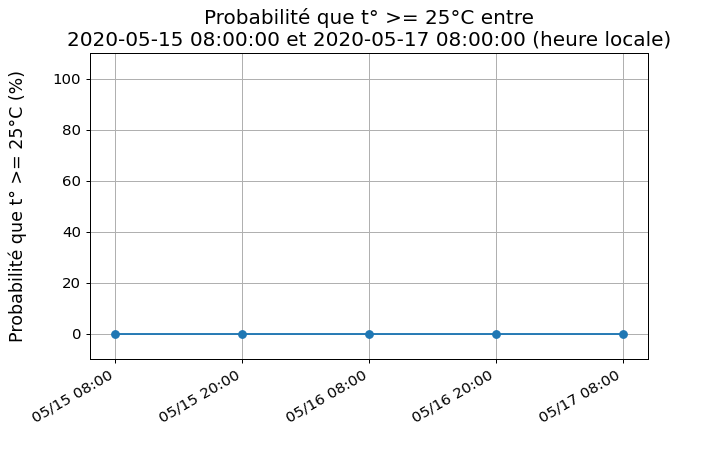

In [7]:
# Prochaine ligne à retirer si le code est utilisé hors de Jupyter Notebook
%matplotlib notebook

# Données affichées sur le graphique
x = local_time
y = pixel_value

# Titre du graphique
title = (f'Probabilité que t° >= 25°C entre\n{local_time[0]}' +
         f' et {local_time[len(local_time) - 1]} (heure locale)')

# Titre des axes
xlabel = '\nDate et heure'
ylabel = 'Probabilité que t° >= 25°C (%)\n'

# Étendue de l'axe des y
ylim = (-10, 110)


# Création d'une fonction pour faire le graphique
def fig(x, y, title, xlabel, ylabel, ylim):
    # Taille du graphique et des polices
    params = {'legend.fontsize': '14',
              'figure.figsize': (8, 5),
              'axes.labelsize': '14',
              'axes.titlesize': '16',
              'xtick.labelsize': '12',
              'ytick.labelsize': '12'}
    plt.rcParams.update(params)

    # Création du graphique et de son style
    fig, ax = plt.subplots()
    ax.plot(x, y, marker='o', linestyle='-')

    # Titres
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Étendue de l'axe des y
    plt.ylim(ylim)

    # Grille
    plt.grid(True, which='both')

    # Format de la date sur l'axe des x
    plt.gcf().autofmt_xdate()
    my_format = mdates.DateFormatter('%m/%d %H:%M')
    plt.gca().xaxis.set_major_formatter(my_format)

    # Graduation de l'axe des x selon le nombre de points sur le graphique
    # Variable contenant les heures pour lesquelles il y aura des étiquettes:
    hour = []
    for hour_index in range(0, len(x)):
        hour.append(int(x[0 + len(hour)].strftime("%#H")))

    # Étiquette sur l'axe des x pour chaque donnée:
    xticks = mdates.HourLocator(byhour=hour, interval=1)
    # Étiquette sur l'axe des x pour chaque journée seulement:
    xticks_alt = mdates.DayLocator()
    # Marque aux 12 h sur l'axe des x:
    xticks_minor = mdates.HourLocator(byhour=(0, 12), interval=1)

    if len(hour) < 8:
        # Graduation plus précise si peu de données
        ax.xaxis.set_major_locator(xticks)
    else:
        # Graduation plus grossière s'il y a beaucoup de données
        ax.xaxis.set_major_locator(xticks_alt)
        ax.xaxis.set_minor_locator(xticks_minor)

    return fig


fig(x, y, title, xlabel, ylabel, ylim)
plt.show()

Une fois les probabilités obtenues, Arthur doit calculer le rapport coût-perte de faire travailler un deuxième employé à la crèmerie. Comme mentionné plus tôt, Arthur sait qu'en moyenne, la crèmerie accueille 300 clients lorsque la température est de 25°C ou plus et qu'un employé n'est en mesure de servir que 200 clients par jour. Arthur a également calculé qu'un client lui rapporte en moyenne 3,50\\$. Chaque employé a un salaire horaire de 10$ et travaille 8 heures par jour, soit de l'ouverture à la fermeture de la crèmerie. Le coût représente donc le salaire du deuxième employé et les pertes représentent les profits perdus dus aux clients qui n'ont pas pu être servis par un seul employé.

In [8]:
# Données de départ
# Nombre de clients lorsque la température est de 25°C ou plus:
clients_above25 = 300
# Chaque employé peut servir 200 clients/jour:
clients_served = 200
# Un client rapporte en moyenne 3,50$:
profit_per_client = 3.5
# Les employés sont payés 10,00$/h:
salary = 10
# Les employés travaillent 8h par jour:
hours_per_day = 8

# Coût pour ajouter un deuxième employé pendant une journée
cost = hours_per_day * salary

# Profits perdus si un seul employé est présent
# une journée où la température est supérieure à 25°C
losses = (clients_above25 - clients_served) * profit_per_client

# Rapport coût-perte
cost_losses_ratio = cost / losses

# Pour faciliter la lecture des résultats hors de Jupyter Notebook,
# enlever le # au début des prochaines lignes:
# print('\n-----\n')
print(f'Le rapport coût-perte est de {round(cost_losses_ratio, 2)}.')
# print('\n-----\n')

Le rapport coût-perte est de 0.23.


Afin de prendre une décision, Arthur veut comparer la perte moyenne engendrée si un seul employé travaille au coût que représente l'ajout un employé supplémentaire. La perte moyenne se calcule de la manière suivante:

$$Pertes * Probabilité$$

Pour que ce soit avantageux de faire travailler un deuxième employé, la perte moyenne si un seul employé travaille doit être supérieure au coût pour faire travailler un employé de plus donc: 

$$Pertes * Probabilité > Coût$$

Si l'on réarrange l'équation, on obtient: 

$$Probabilité > Coût/Pertes$$

Ainsi, si la probabilité que la température soit égale ou supérieure à 25°C est plus élevée que le rapport coût-perte, Arthur devrait faire travailler deux employés. Dans le cas contraire, il devrait en faire travailler un seul.

Il est possible de visualiser les résultats de l'outil d'aide à la décision sous forme de graphique ou sous forme de tableau. Les deux options sont démontrées ci-dessous.

<IPython.core.display.Javascript object>


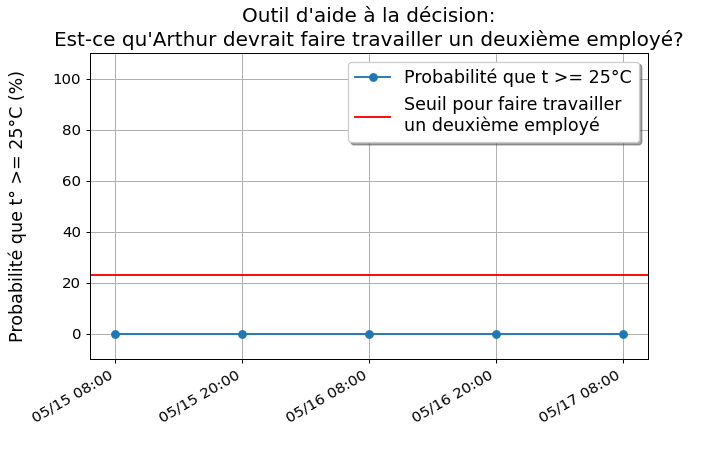

In [9]:
# Titre du graphique
title = ("Outil d'aide à la décision:\n" +
         "Est-ce qu'Arthur devrait faire travailler un deuxième employé?")

# Création du graphique
fig(x, y, title, xlabel, ylabel, ylim)

# Ajout d'une droite représentant le rapport coût-perte
plt.axhline(y=(cost_losses_ratio * 100), color='r', linestyle='-')

# Ajout d'une légende
plt.legend(('Probabilité que t >= 25°C',
            'Seuil pour faire travailler\n' +
            'un deuxième employé'),
           loc='best', 
           shadow=True)

plt.show()

Pour le tableau, une boucle ``for`` est utilisée pour comparer chaque probabilité que la température soit égale ou supérieure à 25°C au seuil minimal pour justifier l'ajout d'un deuxième employé. Ce seuil est égal au rapport coût-perte qui a préalablement été transformé en pourcentage afin d'être du même format que les probabilités pour les besoins de la comparaison.

In [10]:
# Détermination du nombre d'employés qu'il est conseillé d'avoir
employee = [] 
for prediction_index in range(0, len(time)):
    if pixel_value[prediction_index] > (cost_losses_ratio * 100):
        employee.append(2)
    else:
        employee.append(1)
    
# Création du tableau
nb_employees = pandas.DataFrame({'Date et heure locale':  local_time,
                                 'Probabilité que t° >= 25°C (%)': pixel_value,
                                 'Nombre d\'employés recommandés': employee
                                })

# Affichage du tableau
print('Tableau 2: Nombre d\'employés recommandés selon la température')
print(tabulate(nb_employees, 
               headers='keys', 
               tablefmt="pretty", 
               showindex=False))

# Sauvegarde du tableau en format CSV
# Enlever le # au début des lignes suivantes:
# nb_employees.to_csv('nb_employees.csv', 
#                    sep = ';',
#                    index = False,
#                    encoding = "utf-8-sig")


Tableau 2: Nombre d'employés recommandés selon la température
+----------------------+--------------------------------+-------------------------------+
| Date et heure locale | Probabilité que t° >= 25°C (%) | Nombre d'employés recommandés |
+----------------------+--------------------------------+-------------------------------+
| 2020-05-15 08:00:00  |              0.0               |               1               |
| 2020-05-15 20:00:00  |              0.0               |               1               |
| 2020-05-16 08:00:00  |              0.0               |               1               |
| 2020-05-16 20:00:00  |              0.0               |               1               |
| 2020-05-17 08:00:00  |              0.0               |               1               |
+----------------------+--------------------------------+-------------------------------+


## Conclusion

Grâce à cet outil d'aide à la décision, Arthur sait maintenant combien d'employés il devrait faire travailler chaque jour afin de maximiser les profits de sa crèmerie. Suite à la lecture de cet exemple de cas d'utilisation, vous devriez être en mesure de savoir comment accéder à un WMS, effectuer des requêtes incluant des requêtes temporelles et afficher les résultats obtenus sous forme de graphique et de tableau. Vous pouvez donc adapter le code Python de cet exemple pour répondre à vos besoins en changeant les paramètres de la requête et les conditions déterminant quelle décision doit être prise.

[![badge](https://img.shields.io/badge/version%20interactive-binder-F5A252.svg?logo=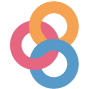)](https://gesis.mybinder.org/binder/v2/gh/marieevelb/jupyter-notebook/9278477595fec6ccdb9ed315fb4359aedc975392?filepath=Arthur.ipynb)